# INTENT DETECTION WITH DOMAIN SPECIFIC BANKING QUERIES

## Steps in this Notebook

1. Analyze the Dataset
2. Clean and preprocess data for Neural Network
3. Create an iterable dataset
4. Build and 5. train a Recurrent Neural Network to get good classification results

## More about the Dataset I used

The Dataset is composed of online banking queries annotated with their corresponding intents. (*Efficent Intent Detection with Dual Sentence Encoders; Iñigo Casanueva and Tadas Temčinas and Daniela Gerz and Matthew Henderson and Ivan Vulić*, https://arxiv.org/abs/2003.04807)

* Dataset consists of roughly 10 000 training and 3 000 testing samples each of them labeled with one of the 77 intents
* The samples consist of different customer requests e.g. *I made a mistake and need to cancel a transaction* which is then labeled with the corresponding intent, in this case *cancel_transfer*
* The challanging part about the dataset: "*The single-domain focus of BANKING77 with a
large number of intents makes it more challenging.
Some intent categories partially overlap with others, which requires fine-grained decisions [...]*" (*Efficent Intent Detection with Dual Sentence Encoders; Iñigo Casanueva and Tadas Temčinas and Daniela Gerz and Matthew Henderson and Ivan Vulić*)

## Goal

* Goal of my work is to create a Neural Network that classifies the Intents, which then can be used to create a Rule Based Chatbot that handles customer requests.

*******************************************************************************************************************************************

### IMPORT STATEMENTS

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk import word_tokenize, PorterStemmer, WordNetLemmatizer
from string import punctuation
import nltk
nltk.download("punkt")

import torch
from torch import nn, optim
from torch.utils import data
import torch.nn.functional as F

from google.colab import drive

from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
#path = "C:/Users/Julian/Documents/DATA SCIENCE PROJECTS/DATA/banking_data"
path = "/content"

banking_data_train = pd.read_csv(path + "/train.csv")
banking_data_test = pd.read_csv(path + "/test.csv")
banking_data = pd.concat([banking_data_test, banking_data_train]) #  concatinate train & test data to get an overview of the whole dataset


### **1.** SOME EXPOLORATORY ANALYSIS

A question we might need to ask ourselfs about the data: *How is the distribution of our categories?*


In [4]:
#  what is the underlying distribution of our dataset? Let's take a look at mean, standard deviation and percentiles.

counts = banking_data["category"].value_counts()
counts.describe()

count     77.000000
mean     169.909091
std       32.942207
min       75.000000
25%      152.000000
50%      167.000000
75%      199.000000
max      227.000000
Name: category, dtype: float64

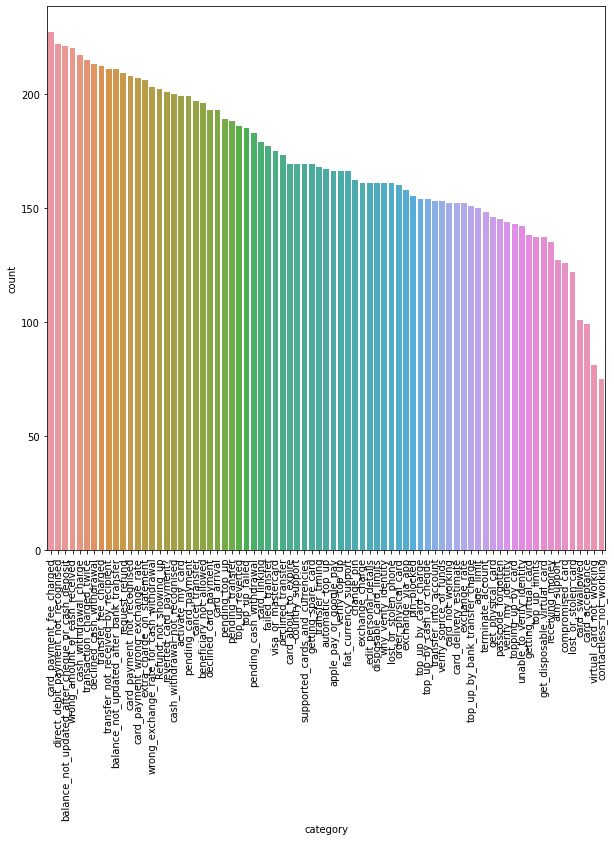

In [5]:
#  histogram of the number of samples in each category to get a gist of the balance between the categories

plt.figure(figsize=(10,10))
plt.xticks(rotation=90)
sns.countplot(data=banking_data, 
             x="category",
             order=banking_data["category"].value_counts().index)

#### **Conclusion** 
There are definitely some categories that have very few samples, compared to our mean amout of samples (~ 170). Let's leave those categories in our dataset, since there is still a good amount of samples that our classifier can learn from.

### **2.** DATA CLEANING AND PREPROCESSING

#### Steps for data cleaning and preprocessing
* Normalize the text (get rid of special characters, *tokenisation*: split each text into words, *stemming*: bring each word to word stem) 
* word vectorization: represent each sentence by a vector so our algorithm can process the textual data
    * we will use one hot encoding, which means every word has its own value in a vector
    * therefore we need to make a lookup table where each word is assigned a unique index (we call it the word_to_idx table)
    * since every sample consists of a sequence of words, we will have a sequence of indices
      
      *sample*: **['i', 'forgot', 'my', 'pin']** ; *vectorized sample*: **[2, 19, 267, 4]**
    * our labels will be in one hot encoded manner: *label*: **'card_acceptance'** ; *one hot encoded label*: **[0, 0, 1, 0, 0, ... , 0, 0]** 

In [6]:
vocabulary = []                                #  vocabulary of our dataset contains each word, that appears in our textual dataset, once
max_sentence_length = 0                        #  maximum sentence length of our samples (important information to bring each training sample to the same length)
categories = banking_data["category"].unique() #  list of all our categories

stemmer = PorterStemmer()                      #  algorithm that attempts to bring each word to its linguistic stem

PADDING = "<pad>"                              #  <pad> is a special symbol which functions as a place holder for our classification algorithm
UNKNOWN = "<unk>"                              #  <unk> is a special symbol that signals our algorithm when we encounter a word that has not been learned during training
vocabulary.append(PADDING)
vocabulary.append(UNKNOWN)

In [7]:
#  function that normalizes our textual data

def normalize(text):
    global max_sentence_length
    
    tokenized_text = [stemmer.stem(word.lower())         
                      for word in word_tokenize(text) 
                      if word not in punctuation]        #  transform each sentence into a list of words; words are lowered and brought to linguistic stem; punctuations are deleted
    if len(tokenized_text) > max_sentence_length:
            max_sentence_length = len(tokenized_text)  
    for word in tokenized_text:
        if word not in vocabulary:
            vocabulary.append(word)                      #  put word into vocabulary list if it has not been seen before
    return tokenized_text

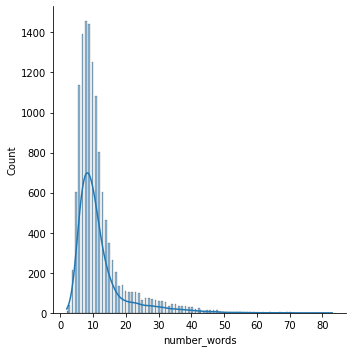

In [8]:
#  apply our normalize(text) function to each sample in our dataset

banking_data["text"] = banking_data["text"].apply(lambda x: normalize(x))


#  show the distribution of number of words for each sample in dataset

banking_data["number_words"] = banking_data["text"].apply(lambda x: len(x))   

sns.displot(data=banking_data,
            x="number_words",
            kde=True)

#### **What does this show us?**

The mean number of words per sample is around 10 words per sample. We defenitely have some samples with >30 words per sample, which is fairly long. This is important when taking into account the Neural Network architecture, since the memory of our recurrent neural network is limited to the length of our sample. Our Network will have problems with very long sentences, so we will have to drop them (let's set our maximum sentence length to 20), scince those sentences will rather disturb the performance of our Network.

In [9]:
#  set max_sentence_length to 20 and drop all samples that are larger than our maximum length

max_sentence_length = 20
banking_data = banking_data.drop(banking_data[banking_data.number_words >= max_sentence_length].index)

#### **Why is this problematic?**

Scince we dropped all samples that are longer than 20 words, we might have a bias in our updated dataset. I am assuming that some categories are linked to a longer sample size. Thats why we need to take a look at the sample size per category again, to make sure the categories are still fairly balanced

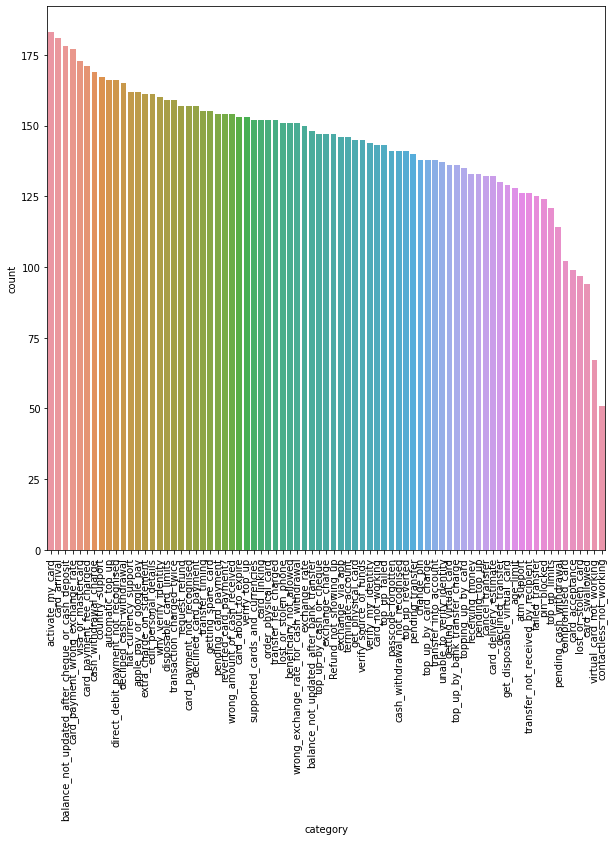

In [10]:
#  histogram of the number of samples in each category to get a gist of the balance between the categories (2ND TIME)

plt.figure(figsize=(10,10))
plt.xticks(rotation=90)
sns.countplot(data=banking_data, 
             x="category",
             order=banking_data["category"].value_counts().index)

#### **Conclusion**

Some categories definitely lost more samples than others and our categories are visibly more imbalanced. Thats why we should drop the categories that have less than 100 samples, to make our classification results in the end even more accurate.

In [11]:
#  drop categories that have a sample size with less than 100

banking_data = banking_data[banking_data["category"].isin(counts[counts > 100].index)]

In [12]:
word_to_idx = {}                           #  define our lookup table  

for idx, word in enumerate(vocabulary):    #  each word in the word_to_idx table will be linked to it's index as follows: {'word': idx}
    word_to_idx[word] = idx

In [13]:
#  function that creates tensors out of our sentences and the corresponding labels

def vectorize(data, categories, num_samples, num_labels, max_sentence_length):
    
    labels = torch.zeros(num_samples, num_labels)                                  #  tensor of shape: [number of samples, number of labels]
    samples = torch.zeros(num_samples, max_sentence_length)                        #  tensor of shape: [number of samples, maximum sentence length]
                                                                                   #  if sample has less words than max_sentence_length the rest will be all zeros which
                                                                                   #  corresponds to our padding symbol <pad> 
    for i, sentence in enumerate(data['text']):                                            
        for j, word in enumerate(sentence):
            samples[i][j] = word_to_idx[word]                                      #  look up corresponding index for word in sample
        labels[i][list(categories).index(data['category'].iloc[i])] = 1            #  look up index of label and put a 1 at the corresponding place of the label vector
        
    return samples, labels

In [14]:
# apply our vectorize() function to transform our data to tensors

samples_tensor, labels_tensor = vectorize(banking_data, categories, len(banking_data), len(categories), max_sentence_length)

### **3.** CREATE BATCH DATASET

#### Use pytorch class Dataset to get a iterable dataset with batches

In [15]:
#  create a iterable dataset

class BankingData(data.Dataset):

    def __init__(self, data, label):
        
        self.data = data
        self.label = label

    def __len__(self):
        
        return len(self.data)

    def __getitem__(self, i):
        
        return self.data[i], self.label[i]  #  get data sample and it's corresponding label

### **4.** BUILD A RECURRENT NEURAL NETWORK FOR CLASSIFICATION

#### RNN Architecture:
* we will use a unidirectional RNN with LSTM Cells (Long Short Term Memory)

In [16]:
#  define RNN class

class RNN(nn.Module):

    def __init__(self, input_dim, embedding_dim, hidden_dim, linear_dim, num_layers, num_classes):
        
        super(RNN, self).__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=word_to_idx[PADDING])   
        self.recurrent = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers)
        self.linear = nn.Linear(hidden_dim, linear_dim)
        self.output = nn.Linear(linear_dim, num_classes)

    def forward(self, text):
        # text shape: [max_sentence_length, batch_size]
        
        embeddings = self.embedding(text)    
        # embeddings shape: [max_sentence_length, batch_size, embedding_dim]
        
        out, (hidden, cell) = self.recurrent(embeddings)
        # hidden shape: [max_sentence_length, batch_size, hidden_dim]
        
        out_linear = self.linear(hidden[-1, :, :])

        return F.softmax(self.output(out_linear), dim=1)                                       #  feed last output of RNN into fully connected NN to get classification result

### **5.** TRAIN RECURRENT NEURAL NETWORK AND SHOW PERFORMANCE RESULTS

## Steps to take:
* initialize all parameters
* create iterable dataset
* initialize RNN, optimizer and loss function
* define train and test function

In [17]:
#  initialize all parameters

n_epochs = 150
learning_rate = 0.0002
INPUT_DIM = len(vocabulary)
EMBEDDING_DIM = 825
LINEAR_DIM = 170
HIDDEN_DIM = 700
NUM_LAYERS = 3
NUM_CLASSES = len(categories)
BATCH_SIZE = 200

In [29]:
#  initialize custom BankingData dataset and randomly split into train and test data  

tensor_banking_data = BankingData(samples_tensor.long(), labels_tensor.float())
tensor_banking_data_train, tensor_banking_data_test = torch.utils.data.random_split(tensor_banking_data, [9000, len(tensor_banking_data)-9000])

#  create iterable dataset

data_train = data.DataLoader(tensor_banking_data_train, batch_size=BATCH_SIZE, shuffle=True)
data_test = data.DataLoader(tensor_banking_data_test, batch_size=BATCH_SIZE, shuffle=True)

In [19]:
#  run training process on gpu if it is available

if torch.cuda.is_available():
    device = torch.device("cuda:0")  
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [30]:
#  initialize RNN, loss function and optimizer

net = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, LINEAR_DIM, NUM_LAYERS, NUM_CLASSES).to(device)

optimizer = optim.Adam(net.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

### **6.** TRAIN THE RNN


In [31]:
#  keep track of accuracy over training process

train_loss_list = []
test_loss_list = []

train_acc_list = []
test_acc_list = []

In [22]:
#  training function

def train(epoch):
    
    correct = 0
    train_loss = 0
    max_idx = 0

    for idx, (sentence, label) in enumerate(data_train):
        
        optimizer.zero_grad()                                                                                             
        prediction = net(torch.transpose(sentence, 0, 1).to(device))                                                     #  forward pass with training samples
        loss = criterion(prediction.to(device), torch.max(label.to(device), 1)[1])                                       #  calculate loss for training prediction
        train_loss += loss.item()
        correct += torch.sum(torch.argmax(prediction.to(device), dim = 1) == torch.argmax(label.to(device), dim = 1))    #  get number of correct predictions
        loss.backward()                                                                                                  #  backpropagation
        optimizer.step()

        max_idx += 1
        
        if idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, idx * len(sentence), len(data_train.dataset),
            100. * idx / len(data_train), loss.item()))
        
    train_loss_list.append(train_loss / max_idx)                                                                         #  keep track of accuracy and loss over time
    train_acc_list.append(100 * correct / len(data_train.dataset))

In [23]:
#  test function

def test():
    
    correct = 0
    test_loss = 0
    max_idx = 0
    
    with torch.no_grad():
        
        for idx, (sentence, label) in enumerate(data_test):
            
            prediction = net(torch.transpose(sentence, 0, 1).to(device))                                                       #  forward pass with test samples
            test_loss += criterion(prediction.to(device), torch.max(label.to(device), 1)[1])                                   #  calculate loss for test samples
            correct += torch.sum(torch.argmax(prediction.to(device), dim = 1) == torch.argmax(label.to(device), dim = 1))      #  get number of correct predictions

            max_idx += 1

        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss / max_idx, correct, len(data_test.dataset),
        100. * correct / len(data_test.dataset)))


        test_loss_list.append(test_loss / max_idx)                                                                             #  keep track of accuracy and loss over time
        test_acc_list.append(100 * correct / len(data_test.dataset))

In [32]:
#  loop over number of epochs to train the RNN

for epoch in range(1, n_epochs + 1):
    train(epoch)                      #  forward and backward pass
    test()                            #  evaluate updated network parameters with test dataset

Train Epoch: 1 [0/9000 (0%)]	Loss: 4.343771
Train Epoch: 1 [2000/9000 (22%)]	Loss: 4.343696
Train Epoch: 1 [4000/9000 (44%)]	Loss: 4.343402
Train Epoch: 1 [6000/9000 (67%)]	Loss: 4.342495
Train Epoch: 1 [8000/9000 (89%)]	Loss: 4.321749

Test set: Avg. loss: 4.3294, Accuracy: 51/1848 (3%)

Train Epoch: 2 [0/9000 (0%)]	Loss: 4.327438
Train Epoch: 2 [2000/9000 (22%)]	Loss: 4.332342
Train Epoch: 2 [4000/9000 (44%)]	Loss: 4.333980
Train Epoch: 2 [6000/9000 (67%)]	Loss: 4.328490
Train Epoch: 2 [8000/9000 (89%)]	Loss: 4.315812

Test set: Avg. loss: 4.3171, Accuracy: 84/1848 (5%)

Train Epoch: 3 [0/9000 (0%)]	Loss: 4.293938
Train Epoch: 3 [2000/9000 (22%)]	Loss: 4.302691
Train Epoch: 3 [4000/9000 (44%)]	Loss: 4.314718
Train Epoch: 3 [6000/9000 (67%)]	Loss: 4.327158
Train Epoch: 3 [8000/9000 (89%)]	Loss: 4.318622

Test set: Avg. loss: 4.3070, Accuracy: 97/1848 (5%)

Train Epoch: 4 [0/9000 (0%)]	Loss: 4.304306
Train Epoch: 4 [2000/9000 (22%)]	Loss: 4.300085
Train Epoch: 4 [4000/9000 (44%)]	Loss:

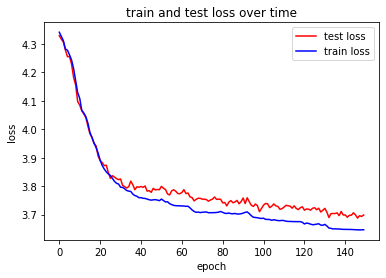

In [33]:
#  plot the training progress

test_loss_list = [value.cpu() for value in test_loss_list]  #  bring tensor from gpu back to cpu

plt.plot(range(len(test_loss_list)), test_loss_list, 'r-', label='test loss')
plt.plot(range(len(train_loss_list)), train_loss_list, 'b-', label='train loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("train and test loss over time")
plt.legend()
plt.show()

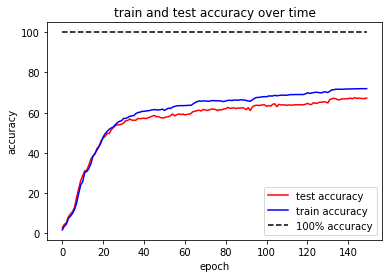

In [34]:
#  plot training and testing accuracy over time

plt.plot(range(len(test_acc_list)), test_acc_list, 'r-', label='test accuracy')
plt.plot(range(len(train_acc_list)), train_acc_list, 'b-', label='train accuracy')
plt.plot(range(len(train_acc_list)), [100 for i in range(len(train_acc_list))], 'k--', label='100% accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("train and test accuracy over time")
plt.legend()
plt.show()

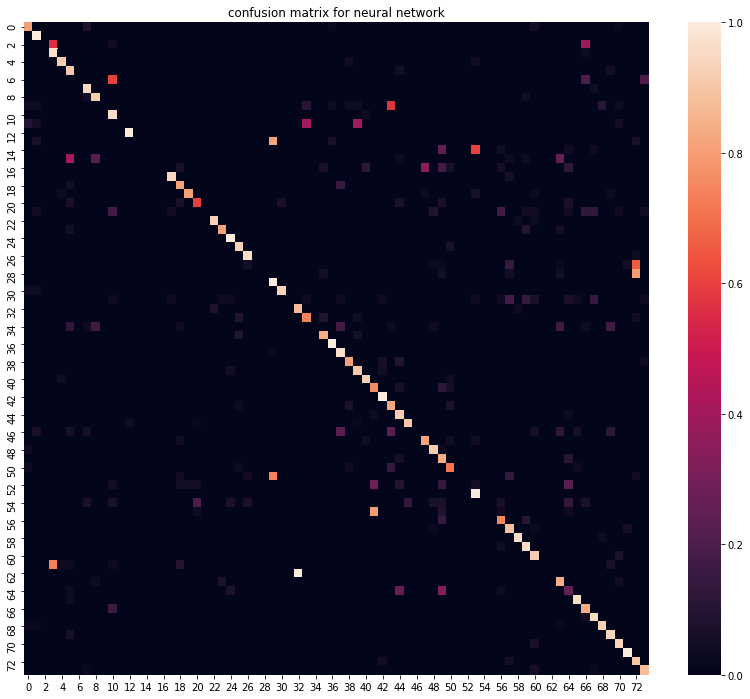

In [35]:
#  calculate the confusion matrix

true_label = []
predicted_label = []

def confusion():

  true_label = []
  predicted_label = []
  
  with torch.no_grad():
        
        for idx, (sentence, label) in enumerate(data_test):
            
            prediction = net(torch.transpose(sentence, 0, 1).to(device))
            predicted_label += [v.cpu().numpy() for v in torch.argmax(prediction, dim = 1)]
            true_label += [v.cpu().numpy() for v in torch.argmax(label, dim = 1)]

  return confusion_matrix(true_label, predicted_label, normalize='true')                        #  create confusion matrix with true label and predicted label
                                                                                              
#  plot the confusion matrix

plt.figure(figsize=(14,12))
plt.title("confusion matrix for neural network")
sns.heatmap(confusion())

#### **RESULTS**

The confusion matrix shows, that some categories are recognized with a high accuracy of more than 80 %. Still, there are some categories that our recurrent neural network is not picking up on, probably because they are hard to distinguish from each other. That's why the accuracy for some categories might be so low. 
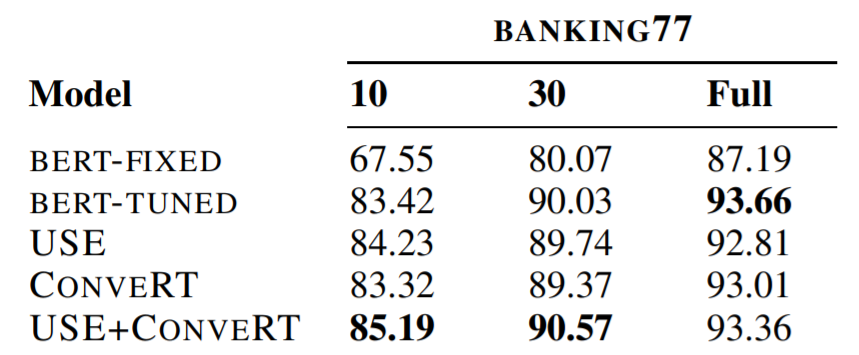  

Considering the algorithms used in the mentioned paper, with the highest test accuracy of about **94 %** (BERT model), are very complex, our simple RNN did fairly good with it's test accuracy of around **67 %**.